# IMPORT PACKAGES

In [1]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

from collections import Counter
from scipy.stats.stats import pearsonr
from string import ascii_letters

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

# Import CSV

In [2]:
airbnb_sfo = pd.read_csv('../../../raw_data/sfo/listings-1.csv')

# Set New Scores

In [3]:
airbnb_sfo['new_agg_scores'] = airbnb_sfo['reviews_per_month'] * airbnb_sfo['review_scores_rating'] / 10

airbnb_sfo['new_agg_scores'].fillna(0, inplace = True)

# Drop Irrelevant Columns

In [4]:
#review_scores_rating
relevant_colmuns = ['price','amenities','new_agg_scores','number_of_reviews','host_verifications','host_listings_count', 'host_response_time', 'host_response_rate', 'host_acceptance_rate','host_is_superhost','host_has_profile_pic','host_identity_verified','accommodates','bathrooms','bedrooms','beds','availability_365','instant_bookable']
for i in airbnb_sfo.columns:
    if i not in relevant_colmuns:
        airbnb_sfo = airbnb_sfo.drop(i, axis = 1, )

# Own Functions

In [5]:
def to_deci(x):
    if type(x)==str:
        x=x.replace('%','')
        x=float(x)/100.0
    return (x)

def to_time(x):
    if x == 'within an hour':
        x='1'
    elif x == 'within a few hours':
        x='4'
    elif x == 'within a day':
        x='24'
    elif x == 'a few days or more':
        x='48'
    else:
        x='96'      
    return x

def to_int(x):
    if x=='f':
        x=x.replace('f','0')
    elif x=='t':
        x=x.replace('t','1')
    else:
        x= '0'
    return int(x)

def to_len(x):
    x = x[1:-1]
    x = x.split(',')
    x = len(x)
    return x

def to_price(x):
    if type(x)==str:
        x=x.replace('$','')
        x=x.replace(',','')
        x=float(x)    
    return (x)

In [6]:
airbnb_sfo

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,amenities,price,availability_365,number_of_reviews,instant_bookable,new_agg_scores
0,within an hour,100%,99%,t,1,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,3,1.0,1.0,2.0,"[""Heating"", ""Hot water"", ""Stove"", ""Iron"", ""Dry...",$132.00,177,257,f,18.527
1,within a day,60%,83%,f,2,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,5,1.0,2.0,3.0,"[""Smoke alarm"", ""Heating"", ""Kitchen"", ""First a...",$235.00,365,111,f,7.938
2,within a few hours,100%,100%,f,10,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,2,4.0,1.0,1.0,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",$56.00,365,19,f,1.176
3,within a few hours,100%,100%,f,10,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,2,4.0,1.0,1.0,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",$56.00,365,8,f,1.023
4,within a few hours,100%,0%,f,2,"['email', 'phone', 'reviews', 'kba']",t,t,4,1.5,2.0,2.0,"[""Heating"", ""Hot water"", ""Stove"", ""Iron"", ""Car...",$750.00,365,28,f,2.037
5,within an hour,100%,96%,t,2,"['email', 'phone', 'reviews', 'offline_governm...",t,t,3,1.0,1.0,1.0,"[""Heating"", ""Hot water"", ""Children\u2019s book...",$169.00,179,736,f,53.606
6,within a few hours,100%,95%,t,1,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,2,1.0,1.0,1.0,"[""Heating"", ""Hot water"", ""Iron"", ""Dryer"", ""Cof...",$150.00,349,531,t,37.882
7,within a day,100%,100%,t,1,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,4,1.0,2.0,3.0,"[""Heating"", ""Hot water"", ""Stove"", ""Iron"", ""Dry...",$200.00,365,337,f,24.288
8,NaN,NaN,0%,f,0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,2,1.0,NaN,1.0,"[""Smoke alarm"", ""Heating"", ""Kitchen"", ""Elevato...",$120.00,364,18,f,1.683
9,within a few hours,97%,79%,t,38,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,3,1.0,3.0,3.0,"[""Refrigerator"", ""Heating"", ""Kitchen"", ""Wifi"",...",$170.00,22,37,f,2.492


In [7]:
airbnb_sfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 18 columns):
host_response_time        5321 non-null object
host_response_rate        5321 non-null object
host_acceptance_rate      6393 non-null object
host_is_superhost         7274 non-null object
host_listings_count       7274 non-null int64
host_verifications        7274 non-null object
host_has_profile_pic      7274 non-null object
host_identity_verified    7274 non-null object
accommodates              7274 non-null int64
bathrooms                 7185 non-null float64
bedrooms                  6430 non-null float64
beds                      7234 non-null float64
amenities                 7274 non-null object
price                     7274 non-null object
availability_365          7274 non-null int64
number_of_reviews         7274 non-null int64
instant_bookable          7274 non-null object
new_agg_scores            7274 non-null float64
dtypes: float64(4), int64(4), object(10)
memory

# Change Data Type of Columns and fill missing data

In [8]:
airbnb_sfo['host_response_rate'] = airbnb_sfo['host_response_rate'].fillna('0%').apply(to_deci)
airbnb_sfo['host_acceptance_rate'] = airbnb_sfo['host_acceptance_rate'].fillna('0%').apply(to_deci)

airbnb_sfo['host_response_time'] = airbnb_sfo['host_response_time'].apply(to_time).astype(int)

airbnb_sfo['host_is_superhost'] = airbnb_sfo['host_is_superhost'].apply(to_int)
airbnb_sfo['host_has_profile_pic'] = airbnb_sfo['host_has_profile_pic'].apply(to_int)
airbnb_sfo['host_identity_verified'] = airbnb_sfo['host_identity_verified'].apply(to_int)
airbnb_sfo['instant_bookable'] = airbnb_sfo['instant_bookable'].apply(to_int)

airbnb_sfo['host_verifications'] = airbnb_sfo['host_verifications'].apply(to_len)
airbnb_sfo['amenities'] = airbnb_sfo['amenities'].apply(to_len)

airbnb_sfo['bathrooms'] = airbnb_sfo['host_response_rate'].fillna(0)
airbnb_sfo['bedrooms'] = airbnb_sfo['host_response_rate'].fillna(0)

airbnb_sfo['price'] = airbnb_sfo['price'].apply(to_price)

In [9]:
airbnb_sfo.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,amenities,price,availability_365,number_of_reviews,instant_bookable,new_agg_scores
0,1,1.0,0.99,1,1,5,1,1,3,1.0,1.0,2.0,30,132.0,177,257,0,18.527
1,24,0.6,0.83,0,2,5,1,1,5,0.6,0.6,3.0,15,235.0,365,111,0,7.938
2,4,1.0,1.00,0,10,5,1,0,2,1.0,1.0,1.0,15,56.0,365,19,0,1.176
3,4,1.0,1.00,0,10,5,1,0,2,1.0,1.0,1.0,14,56.0,365,8,0,1.023
4,4,1.0,0.00,0,2,4,1,1,4,1.0,1.0,2.0,25,750.0,365,28,0,2.037


In [10]:
airbnb_sfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 18 columns):
host_response_time        7274 non-null int32
host_response_rate        7274 non-null float64
host_acceptance_rate      7274 non-null float64
host_is_superhost         7274 non-null int64
host_listings_count       7274 non-null int64
host_verifications        7274 non-null int64
host_has_profile_pic      7274 non-null int64
host_identity_verified    7274 non-null int64
accommodates              7274 non-null int64
bathrooms                 7274 non-null float64
bedrooms                  7274 non-null float64
beds                      7234 non-null float64
amenities                 7274 non-null int64
price                     7274 non-null float64
availability_365          7274 non-null int64
number_of_reviews         7274 non-null int64
instant_bookable          7274 non-null int64
new_agg_scores            7274 non-null float64
dtypes: float64(7), int32(1), int64(10)
memory usag

# Correlation Analysis

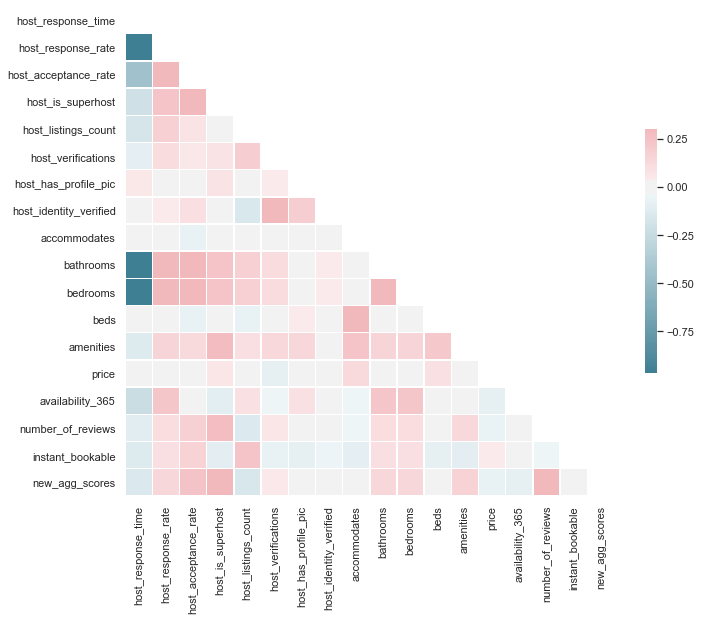

In [17]:
# calculate corr
corr = airbnb_sfo.corr()

# set up heatmap
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [35]:
results = airbnb_sfo.corr().unstack().sort_values(ascending=False)
# print('The correlation of the new_score_reviews against all:', results['new_agg_scores'][1:-1])

print('The correlation of the new_score_reviews against all:\n', results['price'][1:-1])

The correlation of the new_score_reviews against all:
 accommodates              0.125055
beds                      0.092146
host_is_superhost         0.063106
instant_bookable          0.039575
host_identity_verified    0.033771
amenities                 0.016682
bedrooms                  0.016002
host_response_rate        0.016002
bathrooms                 0.016002
host_has_profile_pic      0.006225
host_acceptance_rate     -0.006149
host_listings_count      -0.007006
host_response_time       -0.010502
number_of_reviews        -0.064422
new_agg_scores           -0.073028
availability_365         -0.081647
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\User\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


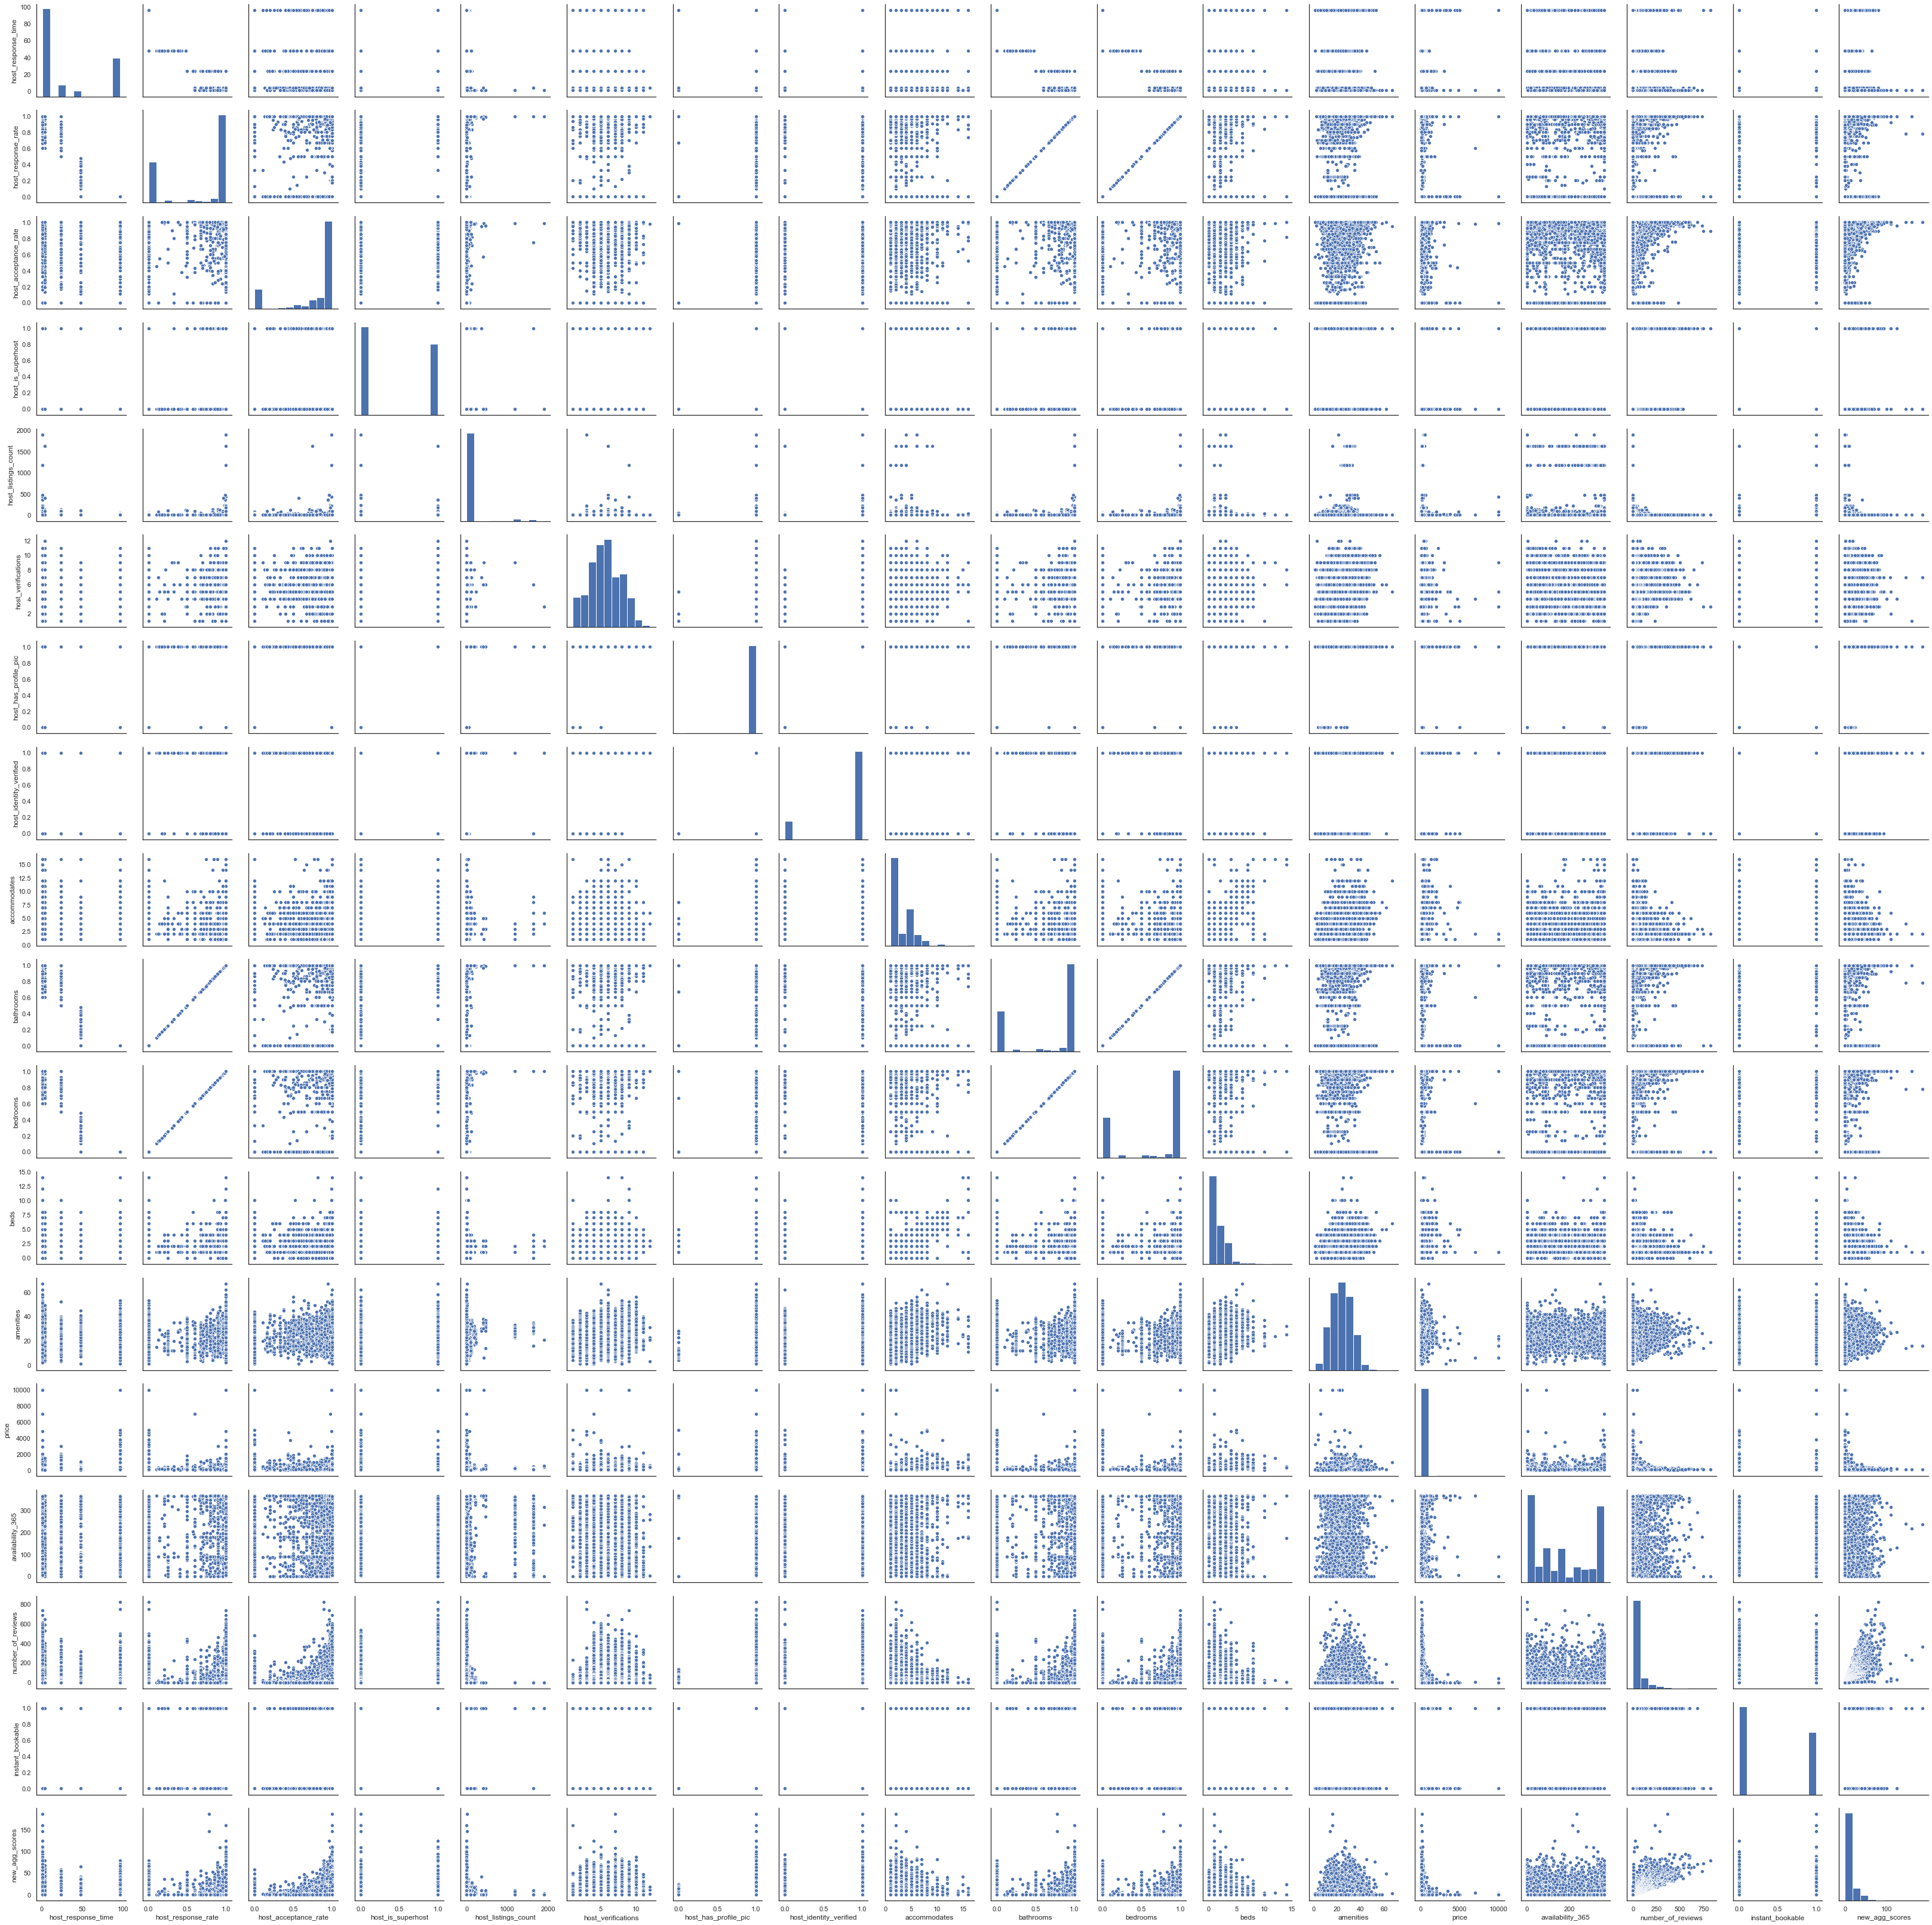

In [18]:
sns.pairplot(airbnb_sfo)

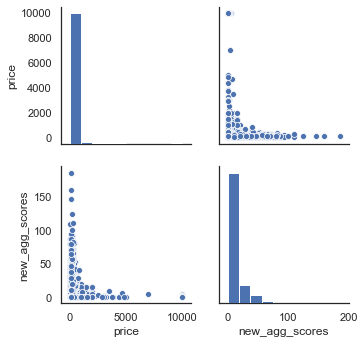

In [28]:
new = airbnb_sfo[['price','new_agg_scores']]
sns.pairplot(new)

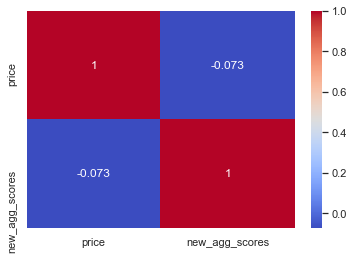

In [29]:
sns.heatmap(new.corr(), annot = True, cmap='coolwarm')

# Determine which determinants influence price the most with  XGBoost

In [13]:
airbnb_sfo.replace([np.inf, -np.inf], np.nan, inplace=True)

X = airbnb_sfo.drop(columns = 'price')
y = airbnb_sfo[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [14]:
#XG Boost
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)

#calculate scores
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

MSE train: 81864.007, test: 118068.620
R^2 train: 0.841, test: 0.768


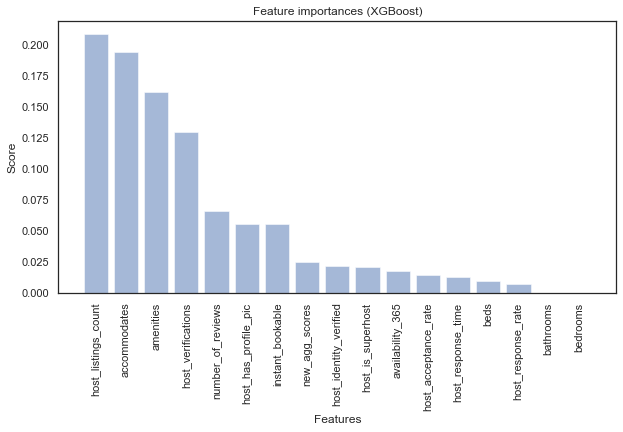

In [15]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances for top features
features = xgb_feature_importances['name']
y_pos = np.arange(len(features))
scores = xgb_feature_importances['score']
 
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (XGBoost)')
 
plt.show()